# Introduction to the EGM2008 model

```{versionadded} 7.3.0

```

heyoka.py includes an implementation of the [EGM2008](https://en.wikipedia.org/wiki/Earth_Gravitational_Model#EGM2008) geopotential model, enabling precise calculations of Earth's gravitational potential and acceleration. This is essential for accurately modeling the trajectories of Earth-orbiting spacecraft, particularly those in [LEO](https://en.wikipedia.org/wiki/Low_Earth_orbit).

Two functions are available: {py:func}`heyoka.model.egm2008_pot()`, for the computation of the potential, and {py:func}`heyoka.model.egm2008_acc()`, for the computation of the acceleration. Both functions require as input a Cartesian position in the Earth-centred Earth-fixed [WGS84](https://en.wikipedia.org/wiki/World_Geodetic_System#WGS84) frame, which, for astrodynamical applications, can be considered coincident with the [ITRS](https://en.wikipedia.org/wiki/International_Terrestrial_Reference_System_and_Frame).

## Gravity on the reference ellipsoid

For this tutorial, we will be computing the gravitational acceleration on Earth's [reference ellipsoid](https://en.wikipedia.org/wiki/Earth_ellipsoid). We begin with the introduction of symbolic variables representing the geodetic latitude and longitude:

In [2]:
import heyoka as hy

lat, lon = hy.make_vars("lat", "lon")

Next, we formulate the analytical expression for the gravitational acceleration as a function of latitude and longitude via the {py:func}`~heyoka.model.egm2008_acc()` function:

In [4]:
acc_model = hy.model.egm2008_acc(hy.model.geo2cart([0.0, lat, lon]), n=80, m=80)

There are several things to note here.

To begin with, recall how {py:func}`~heyoka.model.egm2008_acc()` accepts in input a position in Cartesian coordinates. Here, however, we want to express the acceleration as a function of latitude and longitude, thus we use the {py:func}`~heyoka.model.geo2cart()` function to convert from geodetic coordinates to Cartesian coordinates. In the conversion, we set the geodetic height $h$ to zero, so that we will be computing the acceleration at "sea level".

Additionally, in the invocation of {py:func}`~heyoka.model.egm2008_acc()`, we supply as ``n`` and ``m`` parameters the maximum degree and order of the expansion of the geopotential in [spherical harmonics](https://en.wikipedia.org/wiki/Spherical_harmonics). Higher values of ``n`` and ``m`` result in a more accurate calculation, at the price of increased computational complexity.

We can now proceed to the construction of a [compiled function](<./compiled_functions.ipynb>) for the numerical evaluation of the acceleration:

In [ ]:
cf = hy.cfunc(
    acc_model,
    [lat, lon],
    compact_mode=True,
)

We are now ready to compute the acceleration on a grid of latitudes and longitudes. We will be using [sphere point picking](https://mathworld.wolfram.com/SpherePointPicking.html) to select uniformly-distributed locations on the reference ellipsoid:

In [11]:
import numpy as np

# Generate a grid of latitudes and longitudes (500x500).
nsamples = 500
u = np.linspace(0, 1.0, nsamples)
v = np.linspace(0, 1.0, nsamples)
lons = 2 * np.pi * u
lats = np.pi / 2 - np.arccos(2 * v - 1)
lons, lats = np.meshgrid(lons, lats)
cf_grid = np.ascontiguousarray([lats.flatten(), lons.flatten()])

# Compute the acceleration on the grid.
acc = np.linalg.norm(cf(cf_grid), axis=0)

We can now visualise the acceleration on the reference ellipsoid with the help of [cartopy](https://github.com/SciTools/cartopy):

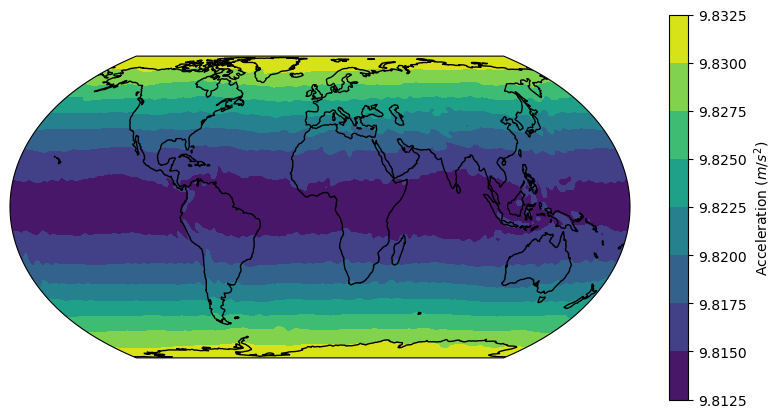

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.EqualEarth())

cf = ax.contourf(
    np.rad2deg(lons),
    np.rad2deg(lats),
    acc.reshape((500, 500)),
    transform=ccrs.PlateCarree(),
    cmap="viridis",
)
ax.coastlines()
ax.set_global()
plt.colorbar(
    cf, ax=ax, orientation="vertical", label=r"Acceleration $\left(m/s^2\right)$"
);

We can see how, as expected, the acceleration is highest at the poles, due to Earth's flattening. Also, despite the fact that we are not using a high-resolution model, the [Indian Ocean Geoid Low](https://en.wikipedia.org/wiki/Indian_Ocean_Geoid_Low) is also clearly visible.